In [1]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import joypy
import requests
import json

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor


import tracemalloc
import time
import yellowbrick
from yellowbrick.regressor import ResidualsPlot, CooksDistance
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot

import lime 
from lime import lime_tabular
import shap
shap.initjs()
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('df_HDB.csv')
y = df[['resale_price']]
X = df.drop(['resale_price','town', 'year'], axis=1)

In [3]:
def tracing_start():
    tracemalloc.stop()
    print("nTracing Status : ", tracemalloc.is_tracing())
    tracemalloc.start()
    print("Tracing Status : ", tracemalloc.is_tracing())
def tracing_mem():
    first_size, first_peak = tracemalloc.get_traced_memory()
    peak = first_peak/(1024*1024)
    print("Peak Size in MB - ", peak)

In [4]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, shuffle=True, random_state=0)

xgbrf = xgb.XGBRFRegressor( 
    # Warning! Parameters: { "silent" } might not be used, hence removed
    colsample_bytree = 0.7,
    n_estimators= 500,
    nthread= 4,
    min_child_weight= 4,
    learning_rate= 0.07,
    max_depth= 7,
    objective = 'reg:squarederror',
    subsample = 0.7
)

tracing_start()
start = time.time()

#Fitting model and train data
xgbrf.fit(X_train, y_train)

xgbrf_score = xgbrf.score(X_train, y_train)   
print("Training data score: ", xgbrf_score) 
 
# cross validataion 
xgbrf_cv_scores = cross_val_score(xgbrf, X_train, y_train, cv=5)
print("Mean cross-validation score: %.4f" % xgbrf_cv_scores.mean())

kfold = KFold(n_splits=10, shuffle=True)
kf_xgbrf_cv_scores = cross_val_score(xgbrf, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.4f" % kf_xgbrf_cv_scores.mean())
end = time.time()
tracing_mem()

tracing_start()
start = time.time()
# Getting ypred (or prediction) values on X_test set
xgbrf_predicted_test = xgbrf.predict(X_test)

# Getting score on test set and calculate mean absolute error, mean squared error and root mean-squared error
xgbrf_test_score = r2_score(y_test, xgbrf_predicted_test)
xgbrf_mse = mean_squared_error(y_test, xgbrf_predicted_test)
xgbrf_mae = mean_absolute_error(y_test, xgbrf_predicted_test)
print("Test data R\u00b2 score: %.4f" % (xgbrf_test_score))
print("Test data Root Mean Squared Error: %.4f" % xgbrf_mse)
print("Test data Mean Absolute Error: %.4f" % xgbrf_mae)
print("Test data Root Mean Squared Absolute Error: %.4f" % (xgbrf_mse**(1/2.0)))
end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

nTracing Status :  False
Tracing Status :  True
Training data score:  -7.498496235183712
Mean cross-validation score: -7.4990
K-fold CV average score: -7.5017
Peak Size in MB -  56.69777488708496
nTracing Status :  False
Tracing Status :  True
Test data R² score: -7.4310
Test data Root Mean Squared Error: 186481257147.6506
Test data Mean Absolute Error: 408371.1097
Test data Root Mean Squared Absolute Error: 431834.7568
time elapsed 65.15836715698242 milli seconds
Peak Size in MB -  2.6676206588745117


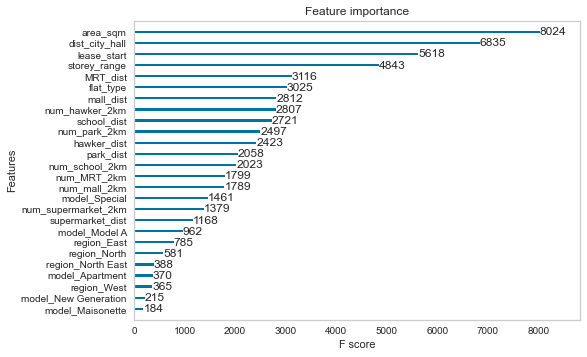

In [5]:
# Plot feature importance
xgb.plot_importance(xgbrf)
plt.rcParams['figure.figsize'] = [10,7]
plt.grid(False)
plt.show()